# Face detction & synthesis
  
  
  
- 얼굴이 포함된 사진을 opencv를 통하여 로드한다.
- load된 이미지를 dlib의 face-detector를 사용하여 얼굴의 위치를 정한다
- 얼굴의 포인트를 이용하여 고양이 수염을 집어 넣는다.

## 1. Import module

In [73]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

## Load Image

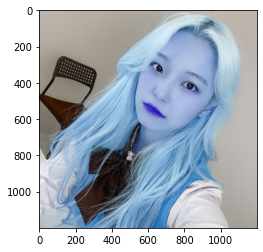

In [74]:
import os
my_image_path = './images/model/jiheon2.jpg'
img_bgr = cv2.imread(my_image_path,-1)    #- OpenCV로 이미지를 읽어서
plt.imshow(img_bgr)
plt.show()

## Convert bgr2rgb

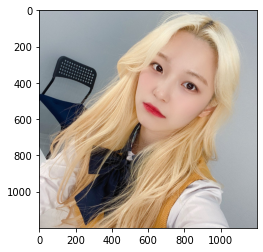

In [75]:

img_ori = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 투명도를 사용하기 위해 RGBA로도 변환함
img_oriA = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGBA)
img_oriA2 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGBA)

plt.imshow(img_oriA)
plt.show()

## Difine face detector

In [76]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_ori, 1)   
print(dlib_rects)

rectangles[[(451, 246) (913, 708)]]


## Face roi draw  rectangle

rectangles[[(451, 246) (913, 708)]]


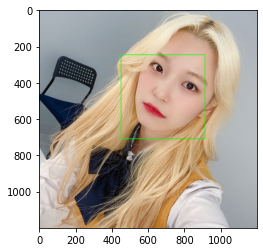

In [77]:
print(dlib_rects)   # 찾은 얼굴영역 좌표
l = 0
t = 0
r = 0
b = 0
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_ori, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_ori)
plt.show()

## Load face landmark data

In [78]:
model_path = './images/sticker/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


 ## Face landmark point index
 
 ![nn](./images/sticker/E-8-8.png)

## Draw point

In [79]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_ori, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

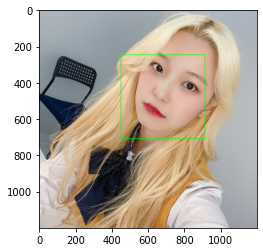

In [80]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_ori, point, 2, (0, 255, 255), -1)
plt.imshow(img_ori)
plt.show()

## Synthesis sticker

In [81]:
face_gradient = 0
x1 = 0
x2 = 0
y1 = 0
y2 = 0

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    #코를 중심으로 잡는다.
    print (landmark[30]) 
    x_nose = landmark[30][0]
    y_nose = landmark[30][1]    
    # 턱과 미간의 좌표를 사용
    x2 = landmark[27][0]
    y2 = landmark[27][1]
    x1 = landmark[8][0]
    y1 = landmark[8][1]

    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x_nose,y_nose) : (%d,%d)'%(x_nose,y_nose))
    print ('(w,h) : (%d,%d)'%(w,h))

# 얼굴이 몇도 돌아갔는지 확인하기 위해 턱과 미간의 포인트를 통하여 기울기를 구함
print(y2)
print(y1)
face_gradient = float((x2-x1) / (y2-y1))
# 기울기를 degree로 바꿔준다.
degree = math.atan(face_gradient) * 180 / math.pi
print(degree)

(667, 462)
(x_nose,y_nose) : (667,462)
(w,h) : (463,463)
367
642
-31.723602957684026


In [82]:
sticker_path = './images/sticker/cat.png'
img_sticker = cv2.imread(sticker_path,-1)
#face roi 크기로 resize
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(463, 463, 4)


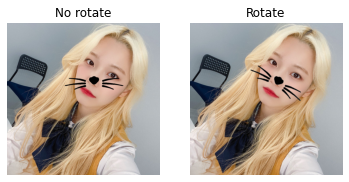

In [83]:
# png 파일의 투명도를 활용하여 수염인 부분만 이미지를 대체함
img_sticker[:,:,3] = np.where(img_sticker[:,:,3] !=255 , 0, 255)
# 스티커를 회전시키기 위해 RotateMatrix를 구하고 어파인 변환을 한다.
# 스티커의 중심 좌표
center_x = w//2
center_y = h//2
# 회전행렬 
M1 = cv2.getRotationMatrix2D((center_x,center_y),degree,1)
img_sticker2 = cv2.warpAffine(img_sticker,M1,(w,h))
for i in range(4):
    #RGBA 에서 alpha(투명도)가 0이 아닌부분만 얼굴 영역의 합성한다.
    img_oriA[ t:t+h,l : l+w,i]  = np.where(img_sticker[:,:,3]!=0,img_sticker[:,:,i],img_oriA[t:t+h,l : l+w,i]).astype(np.uint8)
# 스티커를 회전 시켜서 얼굴에 적용함
for i in range(4):
    #RGBA 에서 alpha(투명도)가 0이 아닌부분만 얼굴 영역의 합성한다.
    img_oriA2[ t:t+h,l : l+w,i]  = np.where(img_sticker2[:,:,3]!=0,img_sticker2[:,:,i],img_oriA2[t:t+h,l : l+w,i]).astype(np.uint8)


fig = plt.figure()
rows = 1
cols = 2
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img_oriA)
ax1.set_title('No rotate')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(img_oriA2)
ax2.set_title('Rotate')
ax2.axis("off")
 
plt.show()

# 고찰  

## 얼굴의 기울기 구하기

- 얼굴이 정면이 아닌 돌아가있는 경우 입히는 스티커의 사진도 돌아가야한다
- detector이 얼굴이 몇도 돌아갔는지가 알수 없다 그래서 스티커의 사진도 돌릴수가 없다.
- 얼굴 회전을 알기 위해 턱과 미간의 포인트의 기울기를 구해 얼굴이 몇도 돌아갔는지 확인
- opencv에서 제공하는 어파인 변환을 쓰기위해 회전변환용 행렬을 구함
- 회전변환용 행렬을 이용하여 어파인 변환을 함
- 변환된 스티커를 다시 원본에 넣어준다.

## 멀리서 찍은 사진, 정면이 아닌 사진
- 멀리서 찍은 사진은 hog detector가 제대로 인식을 할 수 없다
- hog detector은 주변 픽셀들과의 밝기를 방향으로 해서 기존의 얼굴의 형태와 유사한지를 확인한다.
- 멀리서 찍은 사진은 형태가 제대로 나오지않고 16x16의 주변을 보기떄문에 제대로 안될 확률이 높다
- 너무 밝거나 어두운 사진 역시 밝기 변화를 보고 얼굴을 찾아내기 때문에 찾는것이 쉽지 않다.
- 인식이 안됐으므로 영역도 알 수 없고 좌표를 구할 수 없다.